# Lineare Regression

Open in Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/febse/opt2025-de/blob/main/Prediction.ipynb)

In dem Beispiel mit der Produktion- und Distributionsplanung (@sec-production-distribution) war die Nachfrage in den Standorten vorgegeben. Sehr häufig ist es aber so, dass die Nachfrage nicht bekannt ist und geschätzt werden muss.

Als ein einfaches Beispiel für eine Schätzung der Nachfrage nach Backsteinen nehmen wir an, dass die Nachfrage in einem Monat $t$ mit der folgenden Gleichung beschrieben werden kann:

$$
\begin{align*}
\text{Nachfrage}_{t} & = \beta_0 + \beta_1 t + e_t \\
\end{align*}
$$

wobei $\beta_0$ und $\beta_1$ unbekannte Parameter sind, die geschätzt werden müssen, und $e_t$ ein Zufallsfehler ist. Der Index $t$ beschreibt den Monat, in dem die Nachfrage auftritt und läuft von $t=1$ bis $t=T$.

Konkret, nehmen wir an, dass die Nachfrage in jedem Monat durch die folgende Gleichung beschrieben ist:

$$
\begin{align*}
\text{Nachfrage}_{t} = 40 + 0.2 t + e_t
\end{align*}
$$

Um die Notation zu vereinfachen, schreiben wir $y_{t}$ statt $\text{Nachfrage}_{t}$. Für die Fehlerterme
$e_t$ nehmen wir an, dass sie normalverteilt sind mit einem Mittelwert von 0 und einer Varianz von $\sigma^2 = 1$. Ferner nehmen wir an, dass die Fehlerterme $e_t$ unabhängig sind.

In [135]:
%pip install gurobipy

# Zuerst importieren wir pandas und gurobipy

import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

np.random.seed(0)

# Generate some example data

periods = 10

dt = pd.DataFrame({
        "time": np.arange(periods) + 1,
        "noise": np.random.randn(periods) * 2
    })

dt["y"] = 40 + 1.5 * dt["time"] + dt["noise"]
dt

Note: you may need to restart the kernel to use updated packages.


,time,noise,y
0,1,3.528105,45.028105
1,2,0.800314,43.800314
2,3,1.957476,46.457476
3,4,4.481786,50.481786
4,5,3.735116,51.235116
5,6,-1.954556,47.045444
6,7,1.900177,52.400177
7,8,-0.302714,51.697286
8,9,-0.206438,53.293562
9,10,0.821197,55.821197


Text(0, 0.5, 'Backsteine')

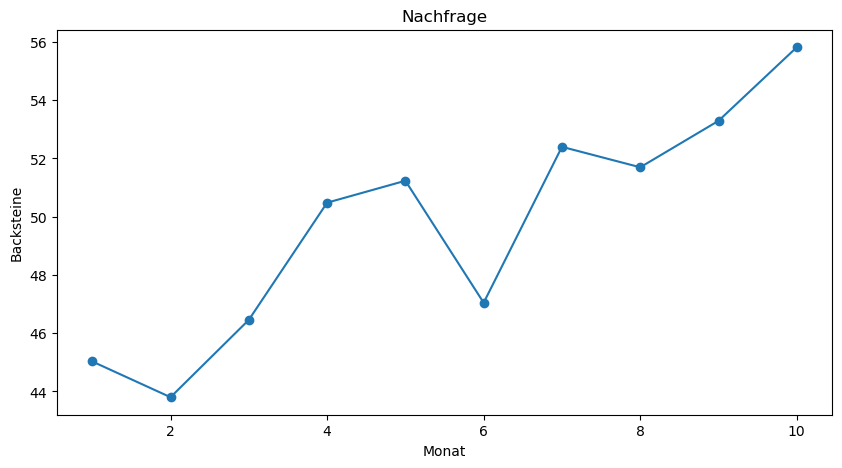

In [136]:
# Plot the data

plt.figure(figsize=(10, 5))
plt.plot(dt["time"], dt["y"], 'o-', label='Data')
plt.title('Nachfrage')
plt.xlabel('Monat')
plt.ylabel('Backsteine')

Üblicherweise kennen wir das Modell (z.B. die Struktur und die Parameter) nicht, sondern wir haben nur eine Zeitreihe von Daten, die wir zur Schätzung der Parameter verwenden können. In unserem Beispiel haben wir also eine Zeitreihe von $T = 50$ Beobachtungen der Nachfrage $y_{t}$ für $t=1,2,\ldots,T$.

Falls wir die Parameter $\beta_0$ und $\beta_1$ kennen würden, könnten wir die Nachfrage in einem Monat $t$ vorhersagen. In der Praxis sind diese Parameter jedoch unbekannt und müssen geschätzt werden.

Zum Beispiel, es seien $\beta_0 = 25, \beta_1 = 0.3$. Um die geschätzte Nachfrage in einem Monat $t$ zu berechnen, setzen wir die Werte in die Gleichung ein:

$$
\begin{align*}
\widehat{\text{Nachfrage}}_{t} & = 25 + 0.3 t \\
\end{align*}
$$

Im Monat $t = 4$ wäre die geschätzte Nachfrage:

$$
\begin{align*}
\widehat{\text{Nachfrage}}_{4} & = 25 + 0.3 \cdot 4 \\
& = 39 + 1.2 \\
& = 40.2 \\
\end{align*}
$$

Die tatsächliche Nachfrage in diesem Monat ist jedoch $43.04$. Der Fehler in der Schätzung beträgt:

$$
\begin{align*}
r_4 & = \text{Nachfrage}_{4} - \widehat{\text{Nachfrage}}_{4} \\
& = 43.04 - 40.2 \\
& = 2.84 \\
\end{align*}
$$

Diese Fehler werden wir **Residuen** oder Abweichungen zwischen Schätzung und tatsächlichem Wert nennen.

Text(0, 0.5, 'Residuen')

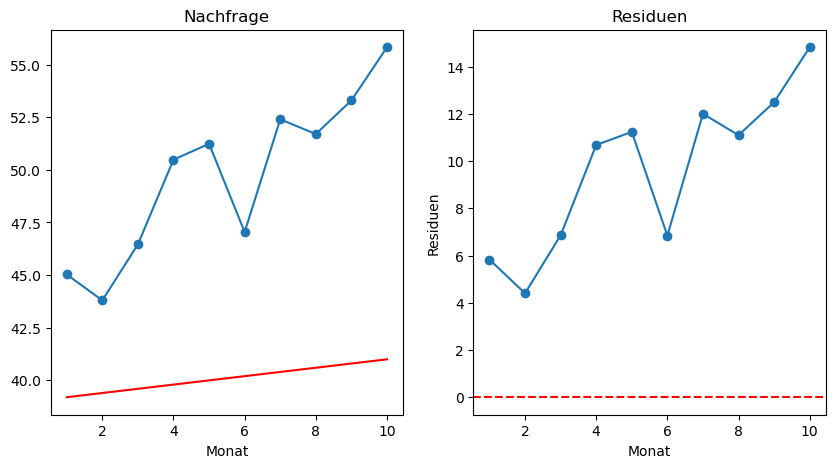

In [137]:
# Plot the data and the trend line

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dt["y_predicted_naive"] = 39 + 0.2 * dt["time"]  # Example trend line
dt["residuals_naive"] = dt["y"] - dt["y_predicted_naive"]

axes[0].plot(dt["time"], dt["y"], 'o-', label='Data')
axes[0].plot(dt["time"], dt["y_predicted_naive"], 'r-', label='Trend Line')
axes[0].set_title('Nachfrage')
axes[0].set_xlabel('Monat')

# Plot the residuals

axes[1].plot(dt["time"], dt["residuals_naive"], 'o-', label='Residuals')
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_title('Residuen')
axes[1].set_xlabel('Monat')
axes[1].set_ylabel('Residuen')


Offensichtlich ist diese Schätzung nicht ganz gut, denn sie unterschätzt die tatsächliche Nachfrage in jedem Monat.
Nun stellt sich die Frage, ob wir _optimale_ Werte für $\beta_0$ und $\beta_1$ finden können, die die Schätzungen verbessern. Falls wir nach Optimalität suchen, müssen wir zuerst klar machen, was wir darunter verstehen.

## Kleinste Quadrate

Die Methode der kleinsten Quadrate (OLS) ist eine Methode zur Schätzung der Parameter $\beta_0$ und $\beta_1$. Sie minimiert die Summe der quadrierten Abweichungen zwischen den beobachteten Werten und den geschätzten Werten:

$$
\begin{align*}
\min_{\beta_0, \beta_1} \sum_{t=1}^{T} (y_t - \hat{y}_t)^2
\end{align*}
$$

Am einfachsten ist es, die Summe der quadrierten Abweichungen nur in Bezug auf $\beta_0$ zu minimieren.

Die Schätzung der Nachfrage in diesem Fall ist:

$$
\hat{y}_t = \hat{\beta}_0
$$

und die Summe der quadrierten Abweichungen ist:

$$
\begin{align*}
\sum_{t=1}^{T} (y_t - \beta_0)^2
\end{align*}
$$

Graphisch ist das eine Parabel, die nach oben geöffnet ist. Der Wert von $\beta_0$ für den die Summe der quadrierten Abweichungen minimal ist, ist der Wert, bei dem die erste Ableitung der Funktion gleich Null ist.

Text(0, 0.5, 'Summe der quadrierten Residuen')

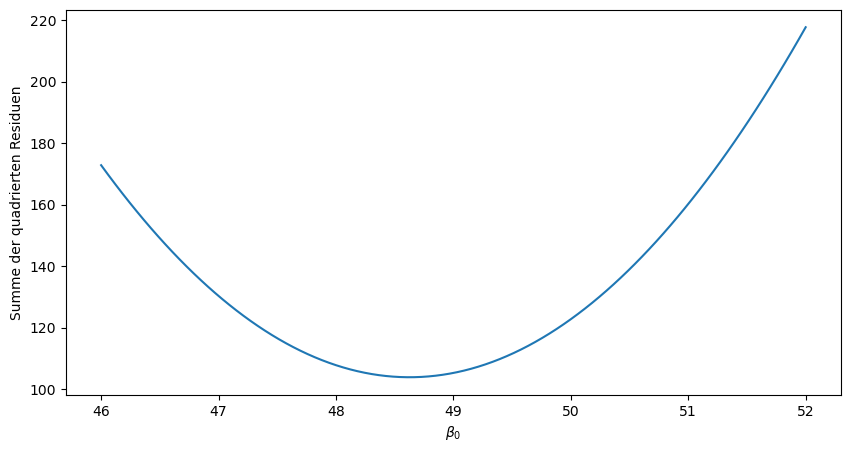

In [138]:
# Visualize the residual sum of squares for a range of beta_0 values

beta_0_values = np.linspace(46, 52, 100)

residuals = np.zeros((len(beta_0_values), periods))

for i in range(len(beta_0_values)):
    y_predicted = beta_0_values[i] + 0.2 * dt["time"]
    residuals[i, :] = dt["y"] - y_predicted
    
# Calculate the residual sum of squares
rss = np.sum(residuals**2, axis=1)

# Plot the residual sum of squares

plt.figure(figsize=(10, 5))
plt.plot(beta_0_values, rss)
plt.xlabel(r'$\beta_0$')
plt.ylabel('Summe der quadrierten Residuen')

Wir können die Ableitung der Funktion berechnen:

$$
\begin{align*}
\frac{d}{d\beta_0} \sum_{t=1}^{T} (y_t - \beta_0)^2 & = \sum_{t=1}^{T} 2(y_t - \beta_0)(-1) \\
& = -2 \sum_{t=1}^{T} (y_t - \beta_0) \\
& = -2 \sum_{t=1}^{T} y_t + 2T \beta_0 \\
& = 0 \\
\end{align*}
$$

Die Lösung ist einfach der Mittelwert der beobachteten Werte:

$$
\begin{align*}
\hat{\beta}_0 & = \frac{1}{T} \sum_{t=1}^{T} y_t \\
& = \bar{y} \\
\end{align*}
$$


In dem Fall mit zwei Koeffizienten $\beta_0$ und $\beta_1$ ist die Schätzung:

$$
\hat{y}_t = \hat{\beta}_0 + \hat{\beta}_1 t
$$

und die Summe der quadrierten Abweichungen ist:

$$
\begin{align*}
\sum_{t=1}^{T} (y_t - (\beta_0 + \beta_1 t))^2
\end{align*}
$$

Text(0.5, 0, 'Quadratsumme der Residuen')

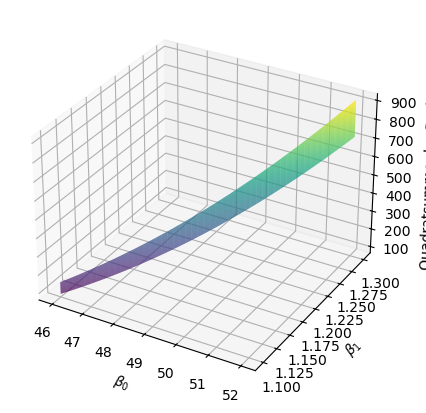

In [ ]:
#| code-fold: true

# Visualize the residual sum of squares for a range of parameters

beta_0_values = np.linspace(46, 52, 100)
beta_1_values = np.linspace(1.1, 1.3, 100)

RSS = np.zeros((len(beta_0_values), len(beta_1_values)))

for i in range(len(beta_0_values)):
    for j in range(len(beta_1_values)):
        y_predicted = beta_0_values[i] + beta_1_values[j] * dt["time"]
        RSS[i, j] = np.sum((dt["y"] - y_predicted) ** 2)

# Plot the RSS surface

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(beta_0_values, beta_1_values, RSS.T, cmap='viridis', edgecolor='none')

ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel('Quadratsumme der Residuen')

Anstatt die Ableitungen der Funktion zu berechnen, werden wir die optimalen Werte von $\beta_0$ und $\beta_1$ 
mit `Gurobi` berechnen.

Wir suchen den Minimum der Funktion:

$$
\begin{align*}
\min_{\beta_0, \beta_1} \sum_{t=1}^{T} r^2_t
\end{align*}
$$

Die Residuen $r_t$ sind:

$$
\begin{align*}
r_t & = y_t - (\beta_0 + \beta_1 t), \quad t = 1,2,\ldots, T\\
\end{align*}
$$

:::{.callout-note}
## Unbeschränkte Variablen

Bei der Umsetzung in `Gurobi` müssen wir darauf achten, dass sowohl die Residuen und die Koeffizienten auch negativ sein können. Die Voreinstellung in `Gurobi` ist, dass die Variablen nichtnegativ sind. Deswegen setzen wir die untere Schranken auf $-\infty$ (`lb=-GRB.INFINITY`).

:::
:::{.callout-note}
## Gurobi Matrixvariablen

Das Program werden wir mit `Gurobi` Matrixvariablen umsetzen. Diese erleichtern 
die Implementierung, denn wir können Schleifen durch Matrixoperationen ersetzen. Beachten Sie, dass
wir in dem Code unten die Variablen durch `m.addMVar` statt `m.addVars` erstellen.

:::



In [ ]:
# Gurobi model for least squares

m = gp.Model("Kleinste Quadrate")

# Hier definieren wir die Variablen für die Koeffizienten beta_0 und beta_1.
beta_0 = m.addMVar(1, lb=-GRB.INFINITY, name="beta_0")
beta_1 = m.addMVar(1, lb=-GRB.INFINITY, name="beta_1")

# Hier definieren wir die Variablen für die Residuen. Die Anzahl der Residuen ist gleich der Anzahl der Beobachtungen (dt.shape[0]).
residuals = m.addMVar(dt.shape[0], lb=-GRB.INFINITY, name="r")

# Einschränkungen für die Residuen

m.addConstr(dt["y"].values - (beta_0 + beta_1 * dt["time"].values) == residuals, name="Residuals")

# Die Zielfunktion ist die Summe der quadrierten Residuen und wir suchen den Minimalwert.

m.setObjective((residuals**2).sum(), GRB.MINIMIZE)

m.write("model-ols.lp")

with open("model-ols.lp", "r") as f:
    print(f.read())


\ Model Kleinste Quadrate
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
 [ 2 r[0] ^2 + 2 r[1] ^2 + 2 r[2] ^2 + 2 r[3] ^2 + 2 r[4] ^2 + 2 r[5] ^2
   + 2 r[6] ^2 + 2 r[7] ^2 + 2 r[8] ^2 + 2 r[9] ^2 ] / 2 
Subject To
 Residuals[0]: - beta_0[0] - beta_1[0] - r[0] = -45.02810469193533
 Residuals[1]: - beta_0[0] - 2 beta_1[0] - r[1] = -43.80031441673444
 Residuals[2]: - beta_0[0] - 3 beta_1[0] - r[2] = -46.45747596821148
 Residuals[3]: - beta_0[0] - 4 beta_1[0] - r[3] = -50.48178639840292
 Residuals[4]: - beta_0[0] - 5 beta_1[0] - r[4] = -51.23511598029994
 Residuals[5]: - beta_0[0] - 6 beta_1[0] - r[5] = -47.04544424024718
 Residuals[6]: - beta_0[0] - 7 beta_1[0] - r[6] = -52.40017683505118
 Residuals[7]: - beta_0[0] - 8 beta_1[0] - r[7] = -51.69728558340461
 Residuals[8]: - beta_0[0] - 9 beta_1[0] - r[8] = -53.29356229641289
 Residuals[9]: - beta_0[0] - 10 beta_1[0] - r[9] = -55.82119700387675
Bounds
 beta_0[0] free
 beta_1[0] free
 r[0] free
 r[1]

In [159]:
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 5 125U, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 10 rows, 12 columns and 30 nonzeros
Model fingerprint: 0x9aba8ede
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+01]
Barrier solved model in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective 2.78574210e+01


In [160]:
# Optimal parameters
beta_0.X, beta_1.X

(array([43.34754259]), array([1.15972798]))

In [161]:
# Calculate the predicted values and residuals
dt["y_predicted_OLS"] = beta_0.X + beta_1.X * dt["time"]
dt["residuals_OLS"] = dt["y"] - dt["y_predicted_OLS"]

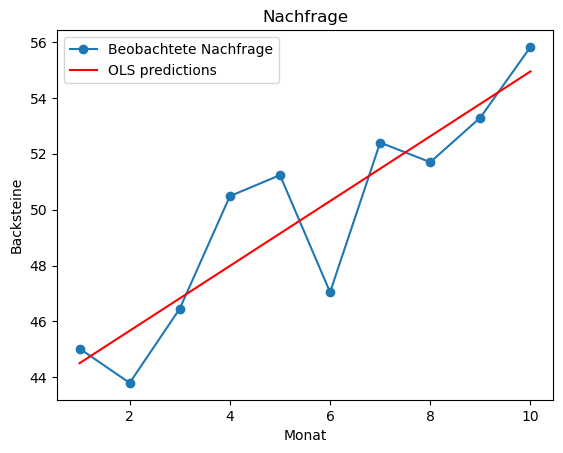

In [164]:
# Plot the data and the predictions

plt.plot(dt["time"], dt["y"], 'o-', label='Beobachtete Nachfrage')
plt.plot(dt["time"], dt["y_predicted_OLS"], 'r-', label='OLS predictions')
plt.xlabel('Monat')
plt.ylabel('Backsteine')
plt.title('Nachfrage')
plt.legend()

In [147]:
# Compare with OLS

from sklearn.linear_model import LinearRegression

X = dt["time"].values.reshape(-1, 1)  # Sklearn erwartet eine Matrix

ols = LinearRegression()
ols.fit(X, dt["y"].values)

ols.coef_, ols.intercept_


(array([1.15972796]), np.float64(43.347542554421686))

## Kleinste absolute Abweichungen

Eine andere Möglichkeit ist es, die Koeffizienten so zu bestimmen, dass die Summe der absoluten Abweichungen minimiert wird. Das heißt, wir minimieren die Summe der Beträge der Abweichungen:

$$
\min_{\beta_0, \beta_1} \sum_{t = 1}^{T} |y_t - (\beta_0 + \beta_1 t )|
$$


Text(0, 0.5, 'Summe der absoluten Residuen')

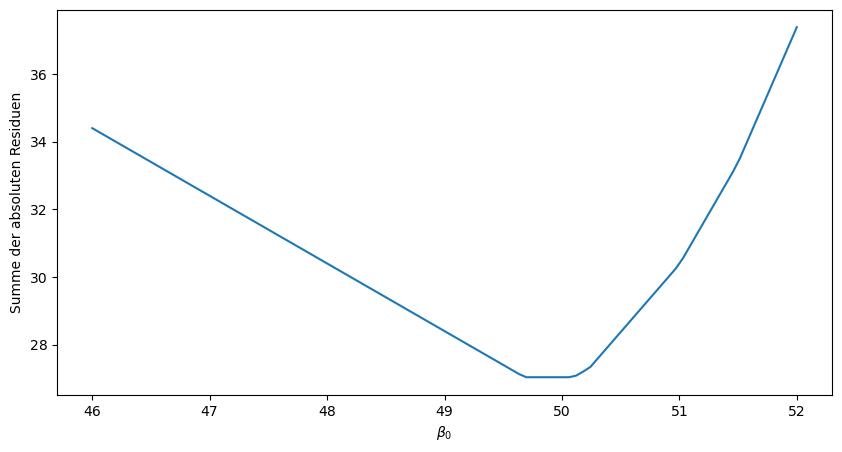

In [125]:
# Compute the sum of absolute residuals for a range of values for beta_0

beta_0_values = np.linspace(46, 52, 100)

residuals = np.zeros((len(beta_0_values), periods))

for i in range(len(beta_0_values)):
    y_predicted = beta_0_values[i] + 0.2 * dt["time"]
    residuals[i, :] = dt["y"] - y_predicted

# Calculate the sum of absolute residuals
sum_abs_residuals = np.sum(np.abs(residuals), axis=1)

# Plot the sum of absolute residuals
plt.figure(figsize=(10, 5))
plt.plot(beta_0_values, sum_abs_residuals)
plt.xlabel(r'$\beta_0$')
plt.ylabel('Summe der absoluten Residuen')

Auf den ersten Blick sieht es so aus, dass diese Aufgabe eher nicht in unsere lineare Welt passt, denn wir haben hier die Betragsfunktion und diese ist nicht linear. Es stellt sich jedoch heraus, dass wir diese Aufgabe mit den Methoden der linearen Optimierung lösen können. Die Residuen $r_t$ sind wie zuvor definiert:

$$
r_t = y_t - (\beta_0 + \beta_1 t)
$$

und wir minimieren die Summe der Beträge der Residuen:

$$
\begin{align*}
\min_{\beta_0, \beta_1} \sum_{t = 1}^{T} |r_t|
\end{align*}
$$

Wir können die Betragsfunktion mit Hilfe von zwei Variablen $r^{+}_t$ und $r^{-}_t$ linearisieren. Wir können jede beliebige Zahl als Differenz von zwei nicht-negativen Zahlen darstellen:

$$
\begin{align*}
5 & = 5 - 0 \\
-3 & = 0 - 3 \\
r_t & = r^{+}_t - r^{-}_t \\
\end{align*}
$$

Der Betrag einer Zahl $x$ ist dann einfach die Summe der beiden nicht-negativen Zahlen:

$$
\begin{align*}
|5| & = 5 + 0 \\
|-3| & = 0 + 3 \\
|r_t| & = r^{+}_t + r^{-}_t \\
\end{align*}
$$

Jetzt können wir die Beträge der Residuen $r_t$ durch die Summe der negativen und positiven Residuen $r^{+}_t$ und $r^{-}_t$ ersetzen. Dann wird die Zielfunktion:

$$
\begin{align*}
\min \sum_{t = 1}^{T} |r_t| & = \min \sum_{t = 1}^{T} (r^{+}_t + r^{-}_t) \\
\end{align*}
$$

Die Einschränkungen sind dann:

$$
\begin{align*}
r_t = r^{+}_t - r^{-}_t & = y_t - (\beta_0 + \beta_1 t), \quad t = 1,\ldots,T\\
r^{+}_t & \geq 0 \\
r^{-}_t & \geq 0 \\
\end{align*}
$$


Bevor wir die Aufgabe mit `Gurobi` umsetzen, möchten wir die Prognose der Nachfrage in Matrixform darstellen, denn diese erleichtert erheblich die Implementierung, insbesondere wenn wir mehr als zwei Koeffizienten haben.

Bei gegebenen Koeffizienten $\beta_0$ und $\beta_1$ können wir die Nachfrage für alle Monate $t$ aufschreiben als:

$$
\begin{align*}
t = 1 \rightarrow & \quad \hat{y}_1 = \beta_0 + \beta_1 \cdot 1 \\
t = 2 \rightarrow & \quad \hat{y}_2 = \beta_0 + \beta_1 \cdot 2 \\
\vdots \\
t = T \rightarrow & \quad \hat{y}_T = \beta_0 + \beta_1 \cdot T \\
\end{align*}
$$

Das können wir in Matrixform schreiben:

$$
\begin{align*}
\hat{y} = \begin{pmatrix} \hat{y}_1 \\ \hat{y}_2 \\ \vdots \\ \hat{y}_T \end{pmatrix} & = \begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix} \beta_0 + \begin{pmatrix} 1 \\ 2 \\ \vdots \\ T \end{pmatrix} \beta_1 \\
\end{align*}
$$

$$
\begin{align*}
\hat{y} & = \begin{pmatrix} 1 & 1  \\ 1 & 2 \\ \vdots & \vdots \\ 1 & T \end{pmatrix} \begin{pmatrix} \beta_0 \\ \beta_1 \end{pmatrix} \\ 
\end{align*}
$$

oder in noch kompakterer Form:

$$
\begin{align*}
\hat{y} & = X \beta \\
\end{align*}
$$

Die Matrix $X$ nennen wir die Designmatrix.



In [148]:
# Um die X-Matrix zu erstellen, verwenden wir die Funktiob dmatrix aus patsy
from patsy import dmatrix

X = dmatrix("1 + time", data = dt)
X

DesignMatrix with shape (10, 2)
  Intercept  time
          1     1
          1     2
          1     3
          1     4
          1     5
          1     6
          1     7
          1     8
          1     9
          1    10
  Terms:
    'Intercept' (column 0)
    'time' (column 1)

In [150]:
# Beispiel: für beta_0 = 40 und beta_1 = 0.2 sind die Prognosen

X @ np.array([40, 0.2])

array([40.2, 40.4, 40.6, 40.8, 41. , 41.2, 41.4, 41.6, 41.8, 42. ])

In [ ]:
m = gp.Model("LAD Regression")

# Wir definieren die Variablen (r+)

# Die Anzahl der Residuen ist gleich der Anzahl der Beobachtungen (Zeilen in X, also X.shape[0])
r_plus = m.addMVar(X.shape[0], name="r_plus")
r_minus = m.addMVar(X.shape[0], name="r_minus")

# Wir definieren die Variablen (beta_0, beta_1)
# Die Anzahl der Parameter ist gleich der Anzahl der Spalten in X (also X.shape[1])
betas = m.addMVar(X.shape[1], lb=-GRB.INFINITY, name="betas")

# Die Einschränkungen

m.addConstr(dt["y"].values - X @ betas == r_plus - r_minus, name="Residuals")

# Die Zielfunktion (Objective Function)

m.setObjective(r_plus.sum() + r_minus.sum(), GRB.MINIMIZE)

m.write("model-lad.lp")
with open("model-lad.lp", "r") as f:
    print(f.read())

m.optimize()


\ Model LAD Regression
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  r_plus[0] + r_plus[1] + r_plus[2] + r_plus[3] + r_plus[4] + r_plus[5]
   + r_plus[6] + r_plus[7] + r_plus[8] + r_plus[9] + r_minus[0]
   + r_minus[1] + r_minus[2] + r_minus[3] + r_minus[4] + r_minus[5]
   + r_minus[6] + r_minus[7] + r_minus[8] + r_minus[9]
Subject To
 Residuals[0]: - r_plus[0] + r_minus[0] - betas[0] - betas[1]
   = -45.02810469193533
 Residuals[1]: - r_plus[1] + r_minus[1] - betas[0] - 2 betas[1]
   = -43.80031441673444
 Residuals[2]: - r_plus[2] + r_minus[2] - betas[0] - 3 betas[1]
   = -46.45747596821148
 Residuals[3]: - r_plus[3] + r_minus[3] - betas[0] - 4 betas[1]
   = -50.48178639840292
 Residuals[4]: - r_plus[4] + r_minus[4] - betas[0] - 5 betas[1]
   = -51.23511598029994
 Residuals[5]: - r_plus[5] + r_minus[5] - betas[0] - 6 betas[1]
   = -47.04544424024718
 Residuals[6]: - r_plus[6] + r_minus[6] - betas[0] - 7 betas[1]
   = -52.40017683505118
 Resi

In [155]:
dt["y_predicted_LAD"] = X @ betas.X
dt["residuals_LAD"] = dt["y"] - dt["y_predicted_LAD"]

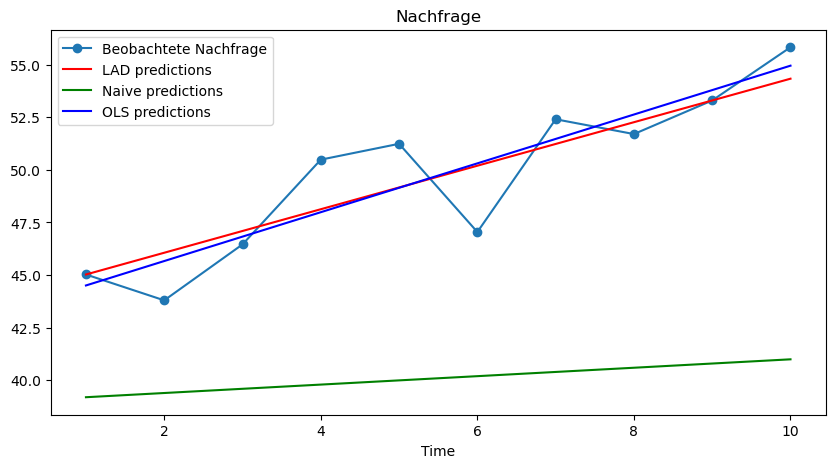

In [ ]:
# Plot the data and the trend line

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(dt["time"], dt["y"], 'o-', label='Beobachtete Nachfrage')
ax.plot(dt["time"], dt["y_predicted_LAD"], 'r-', label='LAD Schätzungen')
ax.plot(dt["time"], dt["y_predicted_naive"], 'g-', label='Naive Schätzungen')
ax.plot(dt["time"], dt["y_predicted_OLS"], 'b-', label='OLS Schätzungen')

ax.set_title('Nachfrage')
ax.set_xlabel('Time')
ax.legend()


In [11]:
from sklearn.linear_model import QuantileRegressor

X = dt["time"].values.reshape(-1, 1)  # Reshape time for sklearn
y = dt["y"].values

qr = QuantileRegressor(quantile=0.5)
y_pred = qr.fit(X, y).predict(X)

qr.coef_, qr.intercept_

(array([0.16112586]), np.float64(41.09536041745628))

In [157]:
from patsy import dmatrix

# Create a design matrix
X = dmatrix('time', dt)
X

DesignMatrix with shape (10, 2)
  Intercept  time
          1     1
          1     2
          1     3
          1     4
          1     5
          1     6
          1     7
          1     8
          1     9
          1    10
  Terms:
    'Intercept' (column 0)
    'time' (column 1)

In [ ]:


m1 = gp.Model("LAD Regression 1")

# Wir definieren die Variablen (r+)
r_plus = m1.addMVar(X.shape[0], name="r_plus")
r_minus = m1.addMVar(X.shape[0], name="r_minus")

# Wir definieren die Variablen (beta_0, beta_1)

betas = m1.addMVar(X.shape[1], name="betas")

# Die Einschränkungen (Constraints)

m1.setObjective(r_plus.sum() + r_minus.sum(), GRB.MINIMIZE)

m1.addConstr(dt["y"].values - X @ betas == r_plus - r_minus, name="Residuals")

m1.write("model1.lp")

with open("model1.lp", "r") as f:
    print(f.read())


\ Model LAD Regression 1
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  r_plus[0] + r_plus[1] + r_plus[2] + r_plus[3] + r_plus[4] + r_plus[5]
   + r_plus[6] + r_plus[7] + r_plus[8] + r_plus[9] + r_plus[10]
   + r_plus[11] + r_plus[12] + r_plus[13] + r_plus[14] + r_plus[15]
   + r_plus[16] + r_plus[17] + r_plus[18] + r_plus[19] + r_plus[20]
   + r_plus[21] + r_plus[22] + r_plus[23] + r_plus[24] + r_plus[25]
   + r_plus[26] + r_plus[27] + r_plus[28] + r_plus[29] + r_plus[30]
   + r_plus[31] + r_plus[32] + r_plus[33] + r_plus[34] + r_plus[35]
   + r_plus[36] + r_plus[37] + r_plus[38] + r_plus[39] + r_plus[40]
   + r_plus[41] + r_plus[42] + r_plus[43] + r_plus[44] + r_plus[45]
   + r_plus[46] + r_plus[47] + r_plus[48] + r_plus[49] + r_minus[0]
   + r_minus[1] + r_minus[2] + r_minus[3] + r_minus[4] + r_minus[5]
   + r_minus[6] + r_minus[7] + r_minus[8] + r_minus[9] + r_minus[10]
   + r_minus[11] + r_minus[12] + r_minus[13] + r_minus[14] + r_minus[1